Este notebook é um tutorial de fine-tunning para few-shot em sentence-transformers, servindo também como benchmark para comparação com fewshot do GPT3/3.5 e zero-shot ChatGPT.

https://github.com/thacio/Few-Shot-Editais-TI

# Instalação dos pacotes

In [ ]:
!pip install datasets sentence_transformers setfit evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preparação do dataset

Para que os resultados sejam reproduzíveis, os parâmetos de geração do dataset não devem ser alterados (*test_size* para a geração dos datasets do few shot e validação, assim como os *seeds* para obter as amostras.

Os valores foram escolhidos de forma a restar 50 exemplos de cada classe no dataset de treino.


## Download e split no dataset

In [ ]:
!wget https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx

--2023-05-10 00:57:23--  https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx [following]
--2023-05-10 00:57:23--  https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702524 (686K) [application/octet-stream]
Saving to: ‘editais_TI.xlsx.2’

editais_TI.xlsx.2   100%[===================>] 686.06K  --.-KB/s    in 0.03s   

2023-05-10 00:57:23 (24.4 MB/s) - ‘editais_TI.xlsx.2’ saved [702524/702524]



Carrega o dataset e elimina as linhas duplicadas

In [ ]:
import pandas
import numpy

df = pandas.read_excel('editais_TI.xlsx')
df['CLASSE_TI'] = df['CLASSE_TI'].replace({0: 'Outras compras', 1: 'Tecnologia da Informação'})
df['DES_OBJETO'] = df['DES_OBJETO'].str.replace('Objeto: Pregão Eletrônico - ', '').str.strip()
df = df[~df['DES_OBJETO'].duplicated()] # Remove colunas com objeto duplicado

df.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,0,153038,12019,O objeto da presente licitação é de empresa pa...,Outras compras
1,1,153054,122019,Registro de Preços para futuras aquisições de ...,Outras compras
2,2,153054,152019,Registro de preços para futuras aquisições de ...,Outras compras
3,3,153054,192019,Contratação de empresa para prestação de servi...,Outras compras
4,4,153054,332019,Registro de preço para futuras aquisições de Ó...,Outras compras


Cria o split de validação e de treino. O split de treino será convertido em few-shot

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
df_train, df_validation = train_test_split(df, test_size=0.9408,random_state=43)

df_validation.loc[df_validation['CLASSE_TI'] == 1]
len(df_validation.loc[df_validation['CLASSE_TI'] == 1])/len(df_validation)

df_train.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
4721,4721,240104,172018,"Aquisição de Licenças de uso de Softwares, gar...",Tecnologia da Informação
3488,3488,160036,112018,Registro de preços para atender as necessidade...,Outras compras
2233,2233,153163,3522018,Registro de Preços para a eventual aquisição d...,Outras compras
5163,5163,253002,182018,Contratação de empresa especializada no fornec...,Tecnologia da Informação
863,863,120195,1652018,Contratação de serviços continuados de limpeza...,Outras compras


## Equilibra as classes no set da instrução e move o restante para a validação

Como estamos trabalhando com few-shot, todos os excessos de classe do dataset de treinamento (que será transformado em few-shot) será transferido para o dataset de validação, de forma a equilibrar as classes.

In [ ]:
import pandas as pd
import numpy as np

# Count the number of 0s and 1s in the 'CLASSE_TI' column of the 'df_train' dataframe
num_0 = df_train['CLASSE_TI'].value_counts()[0]
num_1 = df_train['CLASSE_TI'].value_counts()[1]

# Calculate the difference between the number of 0s and 1s
diff = num_0 - num_1

# If the difference is greater than 0, randomly select that many rows from 'df_train' with label 0 and append them to 'df_validation'
if diff > 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Outras compras'].sample(n=diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is less than 0, randomly select that many rows from 'df_train' with label 1 and append them to 'df_validation'
elif diff < 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Tecnologia da Informação'].sample(n=-diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is already 0, do nothing
else:
    pass

## Estatística do datset


In [ ]:
# Get the number of examples in each dataframe
num_train_examples = len(df_train)
num_validation_examples = len(df_validation)

# Get the number of examples in each class for each dataframe
train_class_counts = df_train['CLASSE_TI'].value_counts()
validation_class_counts = df_validation['CLASSE_TI'].value_counts()

# Calculate the percentage of each class for each dataframe
train_class_percents = train_class_counts / num_train_examples * 100
validation_class_percents = validation_class_counts / num_validation_examples * 100

# Calculate the percentage of the validation set compared to the total
validation_percent_total = num_validation_examples / (num_train_examples + num_validation_examples) * 100

# Calculate the ratio of the number of examples in each class between the validation and training sets
class_ratio_0 = validation_class_counts[0] / (train_class_counts[0]+validation_class_counts[0]) * 100
class_ratio_1 = validation_class_counts[1] / (train_class_counts[1]+validation_class_counts[1]) * 100

# Print out the results
print("Training Data Stats:")
print(f"Total examples: {num_train_examples}")
print(f"Class 0 count: {train_class_counts[0]}, Class 0 percent: {train_class_percents[0]:.2f}%")
print(f"Class 1 count: {train_class_counts[1]}, Class 1 percent: {train_class_percents[1]:.2f}%")
print()

print("Validation Data Stats:")
print(f"Total examples: {num_validation_examples}")
print(f"Class 0 count: {validation_class_counts[0]}, Class 0 percent: {validation_class_percents[0]:.2f}%")
print(f"Class 1 count: {validation_class_counts[1]}, Class 1 percent: {validation_class_percents[1]:.2f}%")
print()
print(f"Percentage of validation set compared to total: {validation_percent_total:.2f}%")
print(f"Class 0 ratio (val/total): {class_ratio_0:.2f}%")
print(f"Class 1 ratio (val/total): {class_ratio_1:.2f}%")

Training Data Stats:
Total examples: 100
Class 0 count: 50, Class 0 percent: 50.00%
Class 1 count: 50, Class 1 percent: 50.00%

Validation Data Stats:
Total examples: 6545
Class 0 count: 5629, Class 0 percent: 86.00%
Class 1 count: 916, Class 1 percent: 14.00%

Percentage of validation set compared to total: 98.50%
Class 0 ratio (val/total): 99.12%
Class 1 ratio (val/total): 94.82%


Utilizaremos a biblioteca datasets do huggingface para reprodução do mesmo dataset e comparação com o SETFIT

In [ ]:
import datasets
from datasets import load_dataset

ds_train = datasets.Dataset.from_pandas(df_train)
ds_validation = datasets.Dataset.from_pandas(df_validation)

dataset = datasets.DatasetDict({
    'train' : ds_train,
    'validation' : ds_validation
    })

In [ ]:
from datasets import Dataset

# Adaptação de função do setfit
def sample_dataset(dataset: Dataset, label_column: str = "label", num_samples: int = 8, seed: int = 42) -> Dataset:
    """Samples a Dataset to create an equal number of samples per class (when possible)."""
    df = dataset.to_pandas()
    df = df.groupby(label_column)

    # sample num_samples, or at least as much as possible
    df = df.apply(lambda x: x.sample(min(num_samples, len(x)),random_state=seed))
    df = df.reset_index(drop=True)

    all_samples = Dataset.from_pandas(df)
    return all_samples

## Cria o dataset de few-shot

Selecionamos 6 exemplos de cada classe para o few-shot.

Para a validação, selecionaremos 50 exemplos de cada classe, para um total de 100.

In [ ]:
few_shot_dataset = sample_dataset(dataset["train"], label_column="CLASSE_TI", num_samples=6,seed=42)
few_shot_dataset = few_shot_dataset.shuffle(seed=42)
eval_dataset = sample_dataset(dataset["validation"], label_column="CLASSE_TI", num_samples=50,seed=42)
eval_dataset = eval_dataset.shuffle(seed=42)
eval_df = eval_dataset.to_pandas()

In [ ]:
few_shot_dataset_df = few_shot_dataset.to_pandas()
few_shot_dataset_df.to_excel('few_shot_prompt.xlsx', index=False)
print('Dataset do few-shot')
few_shot_dataset_df

Dataset do few-shot


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,__index_level_0__
0,66,20001,42018,Prestação de serviços de operação e suporte da...,Outras compras,66
1,181,201014,52019,"Aquisição de uma Solução de Gestão Jurídica, c...",Tecnologia da Informação,181
2,4466,200109,82018,Registro de preços para eventual aquisição de ...,Tecnologia da Informação,4466
3,1122,130011,82018,Contratação de serviços continuados de analise...,Tecnologia da Informação,1122
4,5619,323031,342018,Contratação de serviços continuados de apoio t...,Tecnologia da Informação,5619
5,4624,200233,82018,Registro de Preço para aquisição de ESPARGIDOR...,Outras compras,4624
6,3431,160106,572018,Registro de preço para possível aquisição de i...,Outras compras,3431
7,5217,254445,3722018,"Registro de Preços, pelo prazo de até 12 meses...",Outras compras,5217
8,3751,160166,202018,"Contratação de serviços de coleta, transporte,...",Outras compras,3751
9,4992,238014,5982018,Solução comunicação privada e corporativa com ...,Tecnologia da Informação,4992


In [ ]:
print('Dataset de validação')
eval_dataset.to_pandas()

Dataset de validação


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras
...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação


## Pré-processamento do dataset

Para o fine-tune do sentence-transformer, devemos transformar as classes de texto em número.

'''
0: 'Outras compras'
1: 'Tecnologia da Informação'
'''

Para isso, aplicaremos a função map que fará essa conversão

In [ ]:
import datasets
from datasets import load_dataset


ds = datasets.DatasetDict({
    'train' : few_shot_dataset,
    'validation' : eval_dataset
    })

# define a função de map para ser aplicada ao dataset
def map_function(examples):
    new_examples = {'Unnamed: 0':[],'COD_UASG':[], 'NUM_ANO_PREGAO':[], 'DES_OBJETO':[], 'CLASSE_TI':[]}
   
    first_key=list(examples.keys())[0]
    for i in range(0,len(examples[first_key])):
        input=f'{examples["DES_OBJETO"][i]}'

        if examples['CLASSE_TI'][i] == 'Outras compras':
            label = 0
        elif examples['CLASSE_TI'][i] == 'Tecnologia da Informação':
            label = 1

        new_examples['DES_OBJETO'].append(input)
        new_examples['CLASSE_TI'].append(label)
        new_examples['Unnamed: 0'].append(examples['Unnamed: 0'][i])
        new_examples['COD_UASG'].append(examples['COD_UASG'][i])
        new_examples['NUM_ANO_PREGAO'].append(examples['NUM_ANO_PREGAO'][i])

    return new_examples

# aplica a função
for key in ds:
    ds[key] = ds[key].map(
          map_function,
          batched=True,
          batch_size=1_000,
          remove_columns=ds[key].column_names,
          num_proc=2
      )

print(ds)
print(ds['train'][0])

Map (num_proc=2):   0%|          | 0/12 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'COD_UASG', 'NUM_ANO_PREGAO', 'DES_OBJETO', 'CLASSE_TI'],
        num_rows: 12
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'COD_UASG', 'NUM_ANO_PREGAO', 'DES_OBJETO', 'CLASSE_TI'],
        num_rows: 100
    })
})
{'Unnamed: 0': 66, 'COD_UASG': 20001, 'NUM_ANO_PREGAO': 42018, 'DES_OBJETO': 'Prestação de serviços de operação e suporte da Central de Atendimento de Telecomunicações do Senado Federal, realizados por equipe técnica residente, nas dependências da Coordenação de Telecomunicações   COOTELE, durante 12 (doze) meses consecutivos, de acordo com as quantidades, periodicidade, especificações, obrigações e demais condições do edital e seus anexos.', 'CLASSE_TI': 0}


# Treino 

## Definição da métrica de avaliação

In [ ]:
import evaluate
from evaluate import load

def metric_fn(predictions,labels):
    result = {}

    exact_match_metric = load("accuracy")
    res = exact_match_metric.compute(predictions=predictions,references=labels)
    result.update({'Accuracy': res['accuracy']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'recall_TI': res['recall']})

    precision_metric = load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'precision_TI': res['precision']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'recall_outros': res['recall']})

    precision_metric = load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'precision_outros': res['precision']})

    return result

In [ ]:
# Calcula a acurácia no dataset de teste
from datasets import load_metric
import torch

def evaluate(model,eval_dataset):
    BATCH_SIZE = 512
    pred=[]
    batch=[]
    labels_batch=[]
    labels=[]

    for i in range(0,len(eval_dataset)):
        batch.append(eval_dataset[i]['DES_OBJETO'])
        labels_batch.append(eval_dataset[i]['CLASSE_TI'])

        if  (i == len(eval_dataset)-1) or (len(batch) % BATCH_SIZE) == 0:
            pred_label=model(batch)
            for prediction in pred_label: pred.append(prediction)        
            for lab in labels_batch: labels.append(lab)
            batch=[]
            labels_batch=[]

    pred =  [tensor_item.tolist() for tensor_item in pred]

    return metric_fn(pred, labels), pred, labels

## Trainer

### Terno sem o tunning dos hiperparâmetros

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

train_dataset = ds['train']
eval_dataset = ds['validation']

# Carrega o modelo
model = SetFitModel.from_pretrained("tgsc/sentence-transformer-ult5-pt-small")

model_size = sum(t.numel() for t in model.model_body.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

# Cria o trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=8,
    num_iterations=2,
    use_amp=False,
    num_epochs=1,
    column_mapping={"DES_OBJETO": "text", "CLASSE_TI": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metric, pred, labels = evaluate(model,eval_dataset)
print(metric)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Model size: 51.0M parameters


Generating Training Pairs:   0%|          | 0/2 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 48
  Num epochs = 1
  Total optimization steps = 6
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

{'Accuracy': 0.8, 'recall_TI': 0.82, 'precision_TI': 0.7884615384615384, 'recall_outros': 0.78, 'precision_outros': 0.8125}


### Treino com tunning dos hiperparâmetros
Aqui vamos treinar o modelo já com os melhores hiper-parâmetros encontrados com o optuna (última seção deste notebook)

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

train_dataset = ds['train']
eval_dataset = ds['validation']


# Estes parâmetros já foram encontrados com o Optuna
hyper_parameters = {'learning_rate': 1.4718297644554772e-05, 'num_epochs': 4, 'batch_size': 32, 'seed': 38, 'num_iterations': 40, 'max_iter': 59, 'solver': 'lbfgs'}

params = {
    "head_params": {
        "max_iter": hyper_parameters['max_iter'],
        "solver": hyper_parameters['solver'],
    }
}

# Carrega o modelo
model = SetFitModel.from_pretrained("tgsc/sentence-transformer-ult5-pt-small", **hyper_parameters)

model_size = sum(t.numel() for t in model.model_body.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

# Cria o trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=hyper_parameters['batch_size'],
    num_iterations=hyper_parameters['num_iterations'],    
    num_epochs=hyper_parameters['num_epochs'],
    seed=hyper_parameters['seed'],
    use_amp=False,
    column_mapping={"DES_OBJETO": "text", "CLASSE_TI": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metric, pred, labels = evaluate(model,eval_dataset)
print(metric)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Model size: 51.0M parameters


Generating Training Pairs:   0%|          | 0/40 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 960
  Num epochs = 4
  Total optimization steps = 120
  Total train batch size = 32


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

{'Accuracy': 0.84, 'recall_TI': 0.8, 'precision_TI': 0.8695652173913043, 'recall_outros': 0.88, 'precision_outros': 0.8148148148148148}


Vamos salvar o resultado

In [ ]:
des_objetos  = eval_dataset['DES_OBJETO']
eval_df =  eval_dataset.to_pandas()
eval_df['CLASSIFICAÇÃO_ST-ULT5'] = ''
classifications = model(des_objetos)
for index, row in eval_df.iterrows():
    if classifications[index]==0:
        eval_df.loc[index, 'CLASSIFICAÇÃO_ST-ULT5']='Outras compras'
    else:
        eval_df.loc[index, 'CLASSIFICAÇÃO_ST-ULT5']='Tecnologia da informação'

    if row['CLASSE_TI']==0:
        eval_df.loc[index, 'CLASSE_TI']='Outras compras'
    else:
        eval_df.loc[index, 'CLASSE_TI']='Tecnologia da informação'

eval_df.to_excel('classificados-st-ult5.xlsx', index=False)

## Matriz de confusão

Outros Precision: 0.815
Outros Recall: 0.880
Outros F1 Score: 0.846

TI Precision: 0.870
TI Recall: 0.800
TI F1 Score: 0.833



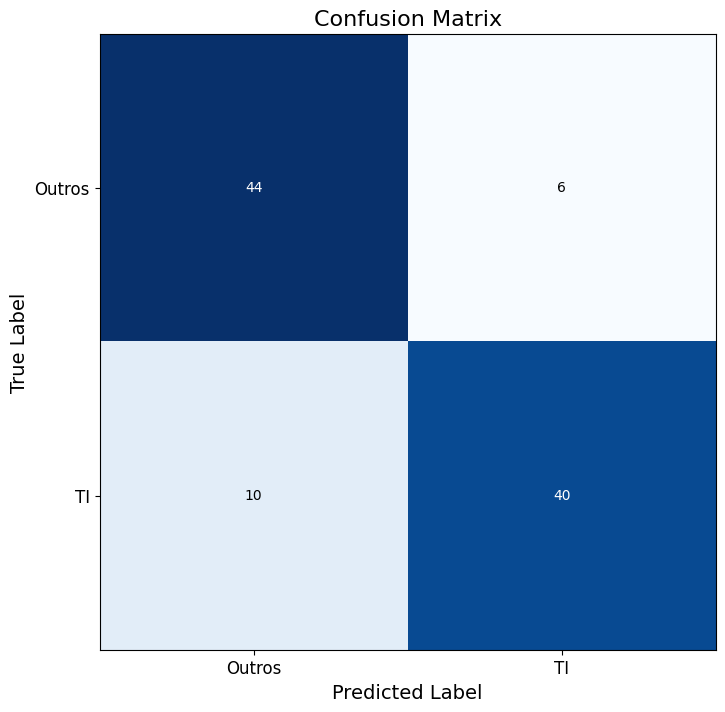

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class_names = ['Outros', 'TI']
cm = confusion_matrix(labels, pred)

precision = precision_score(labels, pred, average=None)
recall = recall_score(labels, pred, average=None)
f1 = f1_score(labels, pred, average=None)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks([0, 1], class_names, fontsize=12)
plt.yticks([0, 1], class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations for confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f'{class_name} Precision: {precision[i]:.3f}')
    print(f'{class_name} Recall: {recall[i]:.3f}')
    print(f'{class_name} F1 Score: {f1[i]:.3f}')
    print('')

plt.show()

# Análise de métricas e avaliação com o restante do dataset

Vamos recuperar agora o dataset de validação completo. Como só utilizamos 16 exemplso para o treino, vamos recuperar todo o restante do dataset de validação, num total de 6629 exemplos de validação. As classes estão desbalanceadas, então adiantamos já que a precisão de TI é baixa, investigaremos o motivo mais a frente.

Como comparação de preço, isso custaria próximo a \$180 doláres (por volta de R$ 1.000,00) de inferência com o modelo GPT3 davinci. (\$0.02 a cada 1,000 tokens)

In [ ]:
# Remove os exemplos do few-shot do nosso dataset original para obtermos o dataset de validação
merged_df = pd.merge(df, few_shot_dataset_df, on='DES_OBJETO', how='inner')
df_full_eval = df[~df.index.isin(merged_df.index)]

In [ ]:
import datasets
from datasets import load_dataset
ds_full_eval = datasets.Dataset.from_pandas(df_full_eval)

ds_full_eval = ds_full_eval.map(
      map_function,
      batched=True,
      batch_size=1_000,
      remove_columns=ds[key].column_names,
      num_proc=2
  )

print(ds_full_eval)

Map (num_proc=2):   0%|          | 0/6633 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'COD_UASG', 'NUM_ANO_PREGAO', 'DES_OBJETO', 'CLASSE_TI', '__index_level_0__'],
    num_rows: 6633
})


In [ ]:
metric, pred, labels = evaluate(model,ds_full_eval)
print(metric)

{'Accuracy': 0.8956731494044927, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.6201754385964913, 'recall_outros': 0.9235927298394212, 'precision_outros': 0.9528490806480976}


Podemos ver com a precisão do edital de TI para o dataset de validação caiu mais de 20%. Investigaremos que, como as classes estão bastante desbalanceadas, as métricas de precisão começam a ficar distorcida.

```
'Tecnologia da Informação': 966 exemplos, 14,56% do total
'Outras compras': 5667 exemplos, 85,43% do total
```

## Investigação da métrica de precisão com upsample na classe de 'Tecnologia da Informação' e downsample em 'Outras compras'

Para verificar que a métrica de precisão sofre prejuízo com o desbalanceamento do dataset, manteremos as mesmas amostras de 'Outras compras' e daremos *up sample* nas classes de TI de forma a que o 'Outras compras' corresponda a 17% do dataset.

In [ ]:
# Criamos datasets apenas com cada classe
ds_TI =  ds_full_eval.filter(lambda example: example["CLASSE_TI"]==1)
ds_outros =  ds_full_eval.filter(lambda example: example["CLASSE_TI"]==0)
print('Exemplos TI',len(ds_TI))
print('Exemplos Outras compras',len(ds_outros))
porcentagem = len(ds_TI)/len(ds_outros)
print('Porcentagem = Exemplos TI/Exemplos Outras compras =',porcentagem)

Filter:   0%|          | 0/6633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6633 [00:00<?, ? examples/s]

Exemplos TI 966
Exemplos Outras compras 5667
Porcentagem = Exemplos TI/Exemplos Outras compras = 0.17046056114346214


Agora damos up sample para ficarmos com mais classes de TI

In [ ]:
from datasets import concatenate_datasets

ds_TI_up_sampled = concatenate_datasets([ds_TI]*int(len(ds_outros)/porcentagem/len(ds_TI)))
ds_eval_upsampled = concatenate_datasets([ds_TI_up_sampled,ds_outros])

print('Exemplos TI',len(ds_TI_up_sampled))
print('Exemplos Outras compras',len(ds_outros))
print('Porcentagem = Exemplos Outras compras/Exemplos ds_TI_up_sampled =',len(ds_outros)/len(ds_TI_up_sampled))

Exemplos TI 32844
Exemplos Outras compras 5667
Porcentagem = Exemplos Outras compras/Exemplos ds_TI_up_sampled = 0.1725429302155645


Métrica do dataset com upsample

In [ ]:
metric, pred, labels = evaluate(model,ds_eval_upsampled)
print(metric)

{'Accuracy': 0.7600945184492742, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9823055862040783, 'recall_outros': 0.9235927298394212, 'precision_outros': 0.3727920227920228}


Recalculando as métricas do dataset de validação completo original apenas ficar mais fácil a comparação

In [ ]:
metric, pred, labels = evaluate(model,ds_full_eval)
print(metric)

{'Accuracy': 0.8956731494044927, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.6201754385964913, 'recall_outros': 0.9235927298394212, 'precision_outros': 0.9528490806480976}


Pode-se perceber que as métricas de precisão foram, de fato, distorcidas, enquanto as de recall se mantiveram inalteradas.

**Recall**

O recall foi inalterado devido ao fato de que repetimos o mesmo dataset e o recall - TP/(TP+FN) - só é calculado utilizando os dados da classe, então ficam inalterados.


**Precision**

A precisão de TI saiu da faixa de 60% para acima de 98%, enquanto a precisão de outras compras saiu de mais de 95% para 37%. A métrica de precisão está distorcida, então é melhor balancear as classes para obter uma visão mais neutra.

Sobre a precisão - TP/(TP+FP)-, os Falsos Positivos crescem a medida que o tamanho da outra classe cresce, o que dimiui essa métrica. Assim, via de regra, quanto maior o desbalanceamento das classes, menor será a precisão da classe com menos exemplos, e maior será a da classe com mais.

---

Para confirmar a análise, faremos o mesmo procedimento, porém em vez de dar up sample nas classes de TI, será feito down sample da classe 'Outras compras', até ela corresponder a 17% da classe de TI

In [ ]:
from datasets import concatenate_datasets

ds_outros_downsampled = ds_outros.shuffle(seed=42).select([*range(int(len(ds_TI)*porcentagem))])
ds_eval_downsampled = concatenate_datasets([ds_TI,ds_outros_downsampled])

print('Exemplos TI',len(ds_TI))
print('Exemplos Outras compras',len(ds_outros_downsampled))
print('Porcentagem = Exemplos Outras compras/Exemplos ds_TI_up_sampled =',len(ds_outros)/len(ds_TI_up_sampled))

metric, pred, labels = evaluate(model,ds_eval_downsampled)
print(metric)

Exemplos TI 966
Exemplos Outras compras 164
Porcentagem = Exemplos Outras compras/Exemplos ds_TI_up_sampled = 0.1725429302155645
{'Accuracy': 0.7610619469026548, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9846796657381616, 'recall_outros': 0.9329268292682927, 'precision_outros': 0.3713592233009709}


Como se esperava, a precisão de TI subiu para 98% e de Outras compras para a faixa de 37%.

Como última verifcação, daremos downsample aleatório na classe de TI para 1/3 do dataset original, e na de outras compras para que fique com a proporção de 17%. Rodaremos algumas vezes para a confirmação da degradação.

In [ ]:
num_tentativas = 10
all_metrics = []
for i in range(num_tentativas):
    print(f'Iterações #{i}')
    ds_TI_downsampled = ds_TI.shuffle(seed=i).select([*range(len(ds_TI)//3)])
    ds_outros_downsampled = ds_outros.shuffle(seed=i).select([*range(int(len(ds_TI_downsampled)*porcentagem))])
    ds_eval_downsample = concatenate_datasets([ds_TI_downsampled,ds_outros_downsampled])
    metric, pred, labels = evaluate(model,ds_eval_downsample)
    all_metrics.append(metric)
    print(metric)

Iterações #0
{'Accuracy': 0.7207446808510638, 'recall_TI': 0.6832298136645962, 'precision_TI': 0.9865470852017937, 'recall_outros': 0.9444444444444444, 'precision_outros': 0.3333333333333333}
Iterações #1
{'Accuracy': 0.773936170212766, 'recall_TI': 0.7422360248447205, 'precision_TI': 0.991701244813278, 'recall_outros': 0.9629629629629629, 'precision_outros': 0.3851851851851852}
Iterações #2
{'Accuracy': 0.7207446808510638, 'recall_TI': 0.6801242236024845, 'precision_TI': 0.9909502262443439, 'recall_outros': 0.9629629629629629, 'precision_outros': 0.33548387096774196}
Iterações #3
{'Accuracy': 0.773936170212766, 'recall_TI': 0.7484472049689441, 'precision_TI': 0.9836734693877551, 'recall_outros': 0.9259259259259259, 'precision_outros': 0.3816793893129771}
Iterações #4
{'Accuracy': 0.7207446808510638, 'recall_TI': 0.6801242236024845, 'precision_TI': 0.9909502262443439, 'recall_outros': 0.9629629629629629, 'precision_outros': 0.33548387096774196}
Iterações #5
{'Accuracy': 0.7659574468085

vamos aumentar agora a participação dos dados Outras compras para plotar o gráfico do comportamento do recall e precision

In [ ]:
num_tentativas = 10
all_metrics = []
porcentagens = [0.17, 0.3, 0.6, 1.0, 2.0, 3.0, 4.0, 5.0]
i=0
for porcentagem in porcentagens:
    print(f'Iterações #{i}')
    i+=1
    ds_TI_downsampled = ds_TI #.shuffle(seed=42).select([*range(len(ds_TI)//2)])
    ds_outros_downsampled = ds_outros.shuffle(seed=i).select([*range(int(len(ds_TI_downsampled)*porcentagem))])
    ds_eval_downsample = concatenate_datasets([ds_TI_downsampled,ds_outros_downsampled])
    metric, pred, labels = evaluate(model,ds_eval_downsample)
    all_metrics.append(metric)
    print(metric)

Iterações #0
{'Accuracy': 0.7619469026548673, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9860529986052998, 'recall_outros': 0.9390243902439024, 'precision_outros': 0.3728813559322034}
Iterações #1
{'Accuracy': 0.7792828685258965, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9751724137931035, 'recall_outros': 0.9377162629757786, 'precision_outros': 0.5113207547169811}
Iterações #2
{'Accuracy': 0.8097087378640777, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9528301886792453, 'recall_outros': 0.9395509499136442, 'precision_outros': 0.6774595267745953}
Iterações #3
{'Accuracy': 0.8286749482401656, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9075738125802311, 'recall_outros': 0.9254658385093167, 'precision_outros': 0.7753686036426712}
Iterações #4
{'Accuracy': 0.8585231193926847, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.824009324009324, 'recall_outros': 0.9218426501035196, 'precision_outros': 0.8730392156862745}
Iterações #5
{'Accuracy': 0.8770703933747

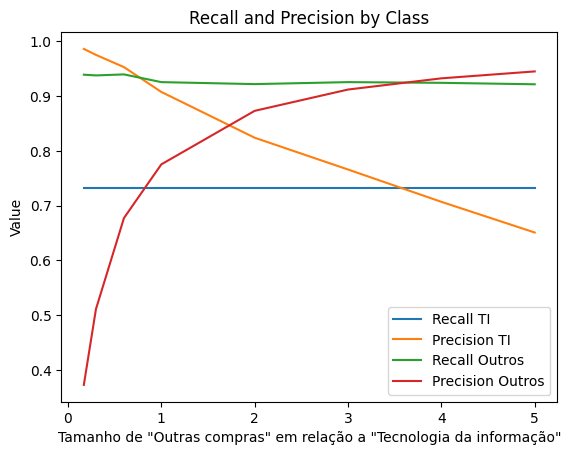

In [ ]:
import matplotlib.pyplot as plt

# Extract recall and precision values from all_metrics list
recall_TI = [m['recall_TI'] for m in all_metrics]
precision_TI = [m['precision_TI'] for m in all_metrics]
recall_outros = [m['recall_outros'] for m in all_metrics]
precision_outros = [m['precision_outros'] for m in all_metrics]

# Create line plot of recall and precision values
fig, ax = plt.subplots()
ax.plot(porcentagens, recall_TI, label='Recall TI')
ax.plot(porcentagens, precision_TI, label='Precision TI')
ax.plot(porcentagens, recall_outros, label='Recall Outros')
ax.plot(porcentagens, precision_outros, label='Precision Outros')
ax.legend()
ax.set_xlabel('Tamanho de "Outras compras" em relação a "Tecnologia da informação"')
ax.set_ylabel('Value')
ax.set_title('Recall and Precision by Class')
plt.show()

Com o gráfico, é possível ver melhor o efeito na precisão com o desbalaceameto do dataset.

## Equalização das classes e testes

O que faremos agora é um *down sample* nas classes 'Outras compras', de forma a ficar com o dataset balanceado para as duas classes.

Para isso, selecionaremos aleatoriamente 966 exemplos da classe 'Outras compras' para formar o dataset com a classe de TI, e avaliaremos em cima dela. Faremos esse procedimento 10 vezes, sempre selecionando 966 exemplos aleatórios dos 5667 possíveis.

In [ ]:
num_tentativas = 10
all_metrics = []
for i in range(num_tentativas):
    print(f'Iterações #{i}')
    ds_outros_downsampled = ds_outros.shuffle(seed=i).select([*range(len(ds_TI))])
    ds_eval_downsample = concatenate_datasets([ds_TI,ds_outros_downsampled])
    metric, pred, labels = evaluate(model,ds_eval_downsample)
    all_metrics.append(metric)
    print(metric)

Iterações #0
{'Accuracy': 0.8250517598343685, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.8994910941475827, 'recall_outros': 0.9182194616977226, 'precision_outros': 0.7739965095986039}
Iterações #1
{'Accuracy': 0.8302277432712215, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9110824742268041, 'recall_outros': 0.9285714285714286, 'precision_outros': 0.7759515570934256}
Iterações #2
{'Accuracy': 0.8250517598343685, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.8994910941475827, 'recall_outros': 0.9182194616977226, 'precision_outros': 0.7739965095986039}
Iterações #3
{'Accuracy': 0.8354037267080745, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.922976501305483, 'recall_outros': 0.9389233954451346, 'precision_outros': 0.7778730703259005}
Iterações #4
{'Accuracy': 0.8286749482401656, 'recall_TI': 0.7318840579710145, 'precision_TI': 0.9075738125802311, 'recall_outros': 0.9254658385093167, 'precision_outros': 0.7753686036426712}
Iterações #5
{'Accuracy': 0.8291925465838

Agora obeteremos as médias das métricas



In [ ]:
# Inicializa a métrica média 
mean_metric = {'Accuracy': 0, 'recall_TI': 0, 'precision_TI': 0, 'recall_outros': 0, 'precision_outros': 0}

for key in mean_metric.keys():
    for metric in all_metrics:
        mean_metric[key] += metric[key]/len(all_metrics)        
print('Média das métricas')
print(mean_metric)

Média das métricas
{'Accuracy': 0.8282091097308488, 'recall_TI': 0.7318840579710146, 'precision_TI': 0.9065785605271204, 'recall_outros': 0.9245341614906833, 'precision_outros': 0.7751872781813616}


Vamos rodar novamente a avaliação no nosso dataset de 100 amostras para ver se o resultado é condizente com a nossa média

In [ ]:
metric, pred, labels = evaluate(model,eval_dataset)
print(metric)

{'Accuracy': 0.84, 'recall_TI': 0.8, 'precision_TI': 0.8695652173913043, 'recall_outros': 0.88, 'precision_outros': 0.8148148148148148}


Podemos ver que, de fato, a métrica do dataset de avaliação de 100 amostras (50 de cada classe) está próxima da média obtida, apesar da variação (para cima e para baixo) entre as métricas. 

Oode haver a influência dos hiper-parâmetros terem sido tunados para otimizar o dataset de validação de 100 original no começo do notebook, e não o dataset completo. 

## **O GPT3.5 e o ChatGPT teriam suas métricas de precisão distorcidas quando avaliados com o dataset inteiro?**

Provavelmente sim, com o crescimento do desbalanceamento, há a distorção natural da classe de precisão, porque os Falsos Positivos são proporcionais ao tamanho da outra classe, enquanto os Verdadeiro Positivos continuam o mesmo. Devido ao alto nível de acerto do DaVinci, espera-se que isso ainda ocorra, mas em um ritmo mais lento.

Para confirmar, seria necessário rodar os testes com os serviços da OpenAI, porém, devido ao elevado custo, e visto que este notebook é apenas um tutorial/análise de um caso específico, esse teste não será realizado. Como mencionado, a validação com  o davinci, de 175B de parâmetros, sairia mais de $170 dólares. (perto de mil reais).

Outra alternativa seria simular o crescimento, mantendo os índices de acerto dos modelos e plotar os gráficos, mas também fica pra próxima.

# Resultados com outros modelos

Vamos testar com o modelo multilingua 'paraphrase-multilingual-mpnet-base-v2', que foi o que encontramos com a melhor performance, que supera a do nosso modelo.

Possui ótimos resultados em diversos datasets para poucos few-shots. Porém, possui metade da janela de contexto do 'sentence-transformer-ult5-pt-small' (514 contra 1024) e tem 5.5 vezes o número de parâmetros, o que pode ser relevante em um grande número de inferências usando cpu.

Se for rodar na gpu, a diferença do tempo de inferências é irrelevante.

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

train_dataset = ds['train']
eval_dataset = ds['validation']


# Estes parâmetros já foram encontrados com o Optuna
hyper_parameters = {'learning_rate': 2.3357440274430127e-05,
 'num_epochs': 3,
 'batch_size': 4,
 'seed': 13,
 'num_iterations': 5,
 'max_iter': 235,
 'solver': 'lbfgs'}

params = {
    "head_params": {
        "max_iter": hyper_parameters['max_iter'],
        "solver": hyper_parameters['solver'],
    }
}

# Carrega o modelo
model = SetFitModel.from_pretrained("paraphrase-multilingual-mpnet-base-v2")
# model = SetFitModel.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased")
# model = SetFitModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-dot-v1")
# model = SetFitModel.from_pretrained("paraphrase-multilingual-MiniLM-L12-v2")

model_size = sum(t.numel() for t in model.model_body.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

# Cria o trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=hyper_parameters['batch_size'],
    num_iterations=hyper_parameters['num_iterations'],    
    num_epochs=hyper_parameters['num_epochs'],
    seed=hyper_parameters['seed'],
    use_amp=False,
    column_mapping={"DES_OBJETO": "text", "CLASSE_TI": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metric, pred, labels = evaluate(model,eval_dataset)
print(metric)

config.json not found in HuggingFace Hub.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Model size: 278.0M parameters


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 120
  Num epochs = 3
  Total optimization steps = 90
  Total train batch size = 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

{'Accuracy': 0.86, 'recall_TI': 0.8, 'precision_TI': 0.9090909090909091, 'recall_outros': 0.92, 'precision_outros': 0.8214285714285714}


Vamos salvar os resultados

In [ ]:
eval_dataset = sample_dataset(dataset["validation"], label_column="CLASSE_TI", num_samples=50,seed=42)
eval_dataset = eval_dataset.shuffle(seed=42)
eval_df = eval_dataset.to_pandas()

des_objetos  = eval_dataset['DES_OBJETO']
eval_df =  eval_dataset.to_pandas()
eval_df['CLASSIFICAÇÃO_ST-multi-mpnet-base-v2'] = ''
classifications = model(des_objetos)
for index, row in eval_df.iterrows():
    if classifications[index]==0:
        eval_df.loc[index, 'CLASSIFICAÇÃO_ST-multi-mpnet-base-v2']='Outras compras'
    else:
        eval_df.loc[index, 'CLASSIFICAÇÃO_ST-multi-mpnet-base-v2']='Tecnologia da informação'

    if row['CLASSE_TI']==0:
        eval_df.loc[index, 'CLASSE_TI']='Outras compras'
    else:
        eval_df.loc[index, 'CLASSE_TI']='Tecnologia da informação'

eval_df.to_excel('classificados-st-multi-mpnet-base-v2.xlsx', index=False)

Comparação do tempo de inferência

'paraphrase-multilingual-mpnet-base-v2'

In [ ]:
import time
model.to('cpu')

batch = 50*['Contratação de serviços continuados de analise, validação e transcrição de dados e eventos atualmente registrados em imagens e microfilmes que integram o acervo de documentos Meteorológicos do Instituto Nacional de Meteorologia - INMET, contemplando a prestação de serviços de digitação, visando a atualização do Banco de Dados Meteorológico conforme condições, quantidades e exigências estabelecidas no presente Edital e seus anexos']

tempo_execucao = 0
for i in range(5):
    inicio = time.time()
    model(batch)
    fim = time.time()
    tempo_execucao += (fim - inicio)/5

# Calcula o tempo de execução
tempo_execucao = fim - inicio
print(f"Média de tempo de execução: {tempo_execucao} segundos para cada batch de 50 textos")

Média de tempo de execução: 11.998582124710083 segundos para cada batch de 50 textos


'sentence-transformer-ult5-pt-small' (vamos retreinar para poder testar o tempo de inferência)

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

train_dataset = ds['train']
eval_dataset = ds['validation']


model = SetFitModel.from_pretrained("tgsc/sentence-transformer-ult5-pt-small")

model_size = sum(t.numel() for t in model.model_body.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

# Cria o trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=8,
    num_iterations=20,
    use_amp=False,
    num_epochs=1,
    column_mapping={"DES_OBJETO": "text", "CLASSE_TI": "label"} # Map dataset columns to text/label expected by trainer
)

trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Model size: 51.0M parameters


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 480
  Num epochs = 1
  Total optimization steps = 60
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
model.to('cpu')

batch = 50*['Contratação de serviços continuados de analise, validação e transcrição de dados e eventos atualmente registrados em imagens e microfilmes que integram o acervo de documentos Meteorológicos do Instituto Nacional de Meteorologia - INMET, contemplando a prestação de serviços de digitação, visando a atualização do Banco de Dados Meteorológico conforme condições, quantidades e exigências estabelecidas no presente Edital e seus anexos']

tempo_execucao
for i in range(5):
    inicio = time.time()
    model(batch)
    fim = time.time()
    tempo_execucao += (fim - inicio)/5

# Calcula o tempo de execução
tempo_execucao = fim - inicio
print(f"Média de tempo de execução: {tempo_execucao} segundos para cada batch de 50 textos")

Média de tempo de execução: 2.7277469635009766 segundos para cada batch de 50 textos


# Busca de hiperparâmetros com optuna

Também podemos fazer uma busca já que o treino é rápido para few-shot, para conseguir ganhar uns pontos de acerto

In [ ]:
!pip install setfit[optuna]

Universo de busca

In [ ]:
from setfit import SetFitModel

def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("tgsc/sentence-transformer-ult5-pt-small", **params)
    # return SetFitModel.from_pretrained("paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial):  # Training parameters
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 5),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 42),
        "num_iterations": trial.suggest_categorical("num_iterations", [5, 10, 20, 40, 60]),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }

Realiza a busca

In [ ]:
import datasets
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset
import datasets

train_dataset = ds['train']
eval_dataset = ds['validation']


trainer = SetFitTrainer(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # eval_dataset=ds_full_eval,
    model_init=model_init,
    column_mapping={"DES_OBJETO": "text", "CLASSE_TI": "label"},
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=40)

In [ ]:
best_run.hyperparameters

Realiza o treinamento com os melhores hiperparâmetros encontrados

In [ ]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()